# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки и пр., как обычно.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Присвоим имена переменным с указанием полного пути.

In [2]:
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

Чтобы кто ни говорил, а здесь я использую head.

In [3]:
df1.head(1)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062


Капитан Очевидность? Но всё же.

In [4]:
df2.head(1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276,-0.005876,3.179103


In [5]:
df3.head(1)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673


Создадим функцию для удобства просмотра распределения признаков, коль уж таблицы здесь три.

In [6]:
def distribution(data):
    print(f"Shape:    {data.shape}")
    print("Na's:         ", data.isna().sum().sum())
    print("duplicates:   ", data.duplicated().sum())
    print("\nРаспределение признаков:")
    data[["f0","f1","f2"]].hist()
    plt.show()

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


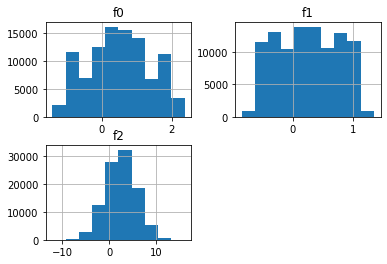

In [7]:
distribution(df1)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


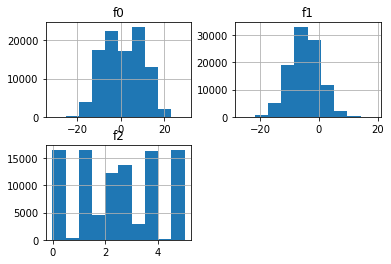

In [8]:
distribution(df2)

Shape:    (100000, 5)
Na's:          0
duplicates:    0

Распределение признаков:


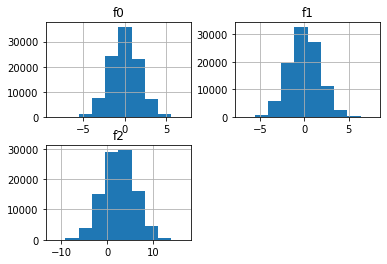

In [9]:
distribution(df3)

<b>Вывод.</b> Дубликатов нет, пропусков нет, признаки распределены не "нормально".

## Обучение и проверка модели

Давайте оттолкнёмся от линейной модели - для предсказания объёмов нефти в скважинах

In [19]:
def split_and_train(data):
    """
    data = датасет.
    
    Оставляет только нужные признаки.
    Делит df на train и test, шкалирует.
    
    Обучает линейную модель
    
    Возвращает tuple с предсказаниями, label'ы, RMSE.
    """
    
    features = data.drop(["product","id"], axis=1)
    target = data["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25, 
                                                                                  random_state=1)
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    lr = LinearRegression(normalize=False)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)
    rmse = (mean_squared_error(predictions, target_valid))**(0.5)
    average_product = sum(predictions) / len(predictions)
    
    print("RMSE: {0:.2f}".format(rmse))
    print("Средний запас: {0:.2f}".format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), rmse)

Выведем данные RMSE и средний запас предсказанного сырья для региона 1, 2 и 3.

In [23]:
print("\n-----------------------------------------")
print("Регион №1")
predictions_1, validation_1, rmse_1 = split_and_train(df1)
print("\n-----------------------------------------")
print("Регион №2")
predictions_2, validation_2, rmse_2 = split_and_train(df2)
print("\n-----------------------------------------")
print("Регион №3")
predictions_3, validation_3, rmse_3 = split_and_train(df3)


-----------------------------------------
Регион №1
RMSE: 37.74
Средний запас: 92.49

-----------------------------------------
Регион №2
RMSE: 0.89
Средний запас: 69.12

-----------------------------------------
Регион №3
RMSE: 39.87
Средний запас: 94.96


<b>Вывод.</b> Самый низкий RMSE и средний запас - во втором регионе.

## Подготовка к расчёту прибыли

Определим исходные значения и точку безубыточности.

In [12]:
budget = 10**10 
barrel = 450000

In [13]:
zero_point = budget / barrel
print("Точка безубыточности: {0:.0f} тыс. баррелей".format(zero_point))

Точка безубыточности: 22222 тыс. баррелей


In [14]:
print("Средний объём нефти в скважине для безубыточного функционирования:", np.ceil(zero_point/200))

Средний объём нефти в скважине для безубыточного функционирования: 112.0


<b>Вывод</b>. Запас сырья в скважинах меньше, чем точка безубыточности.

## Расчёт прибыли и рисков 

Для расчёта прибыли и рисков создадим функцию profit.

In [15]:
def profit(predictions, target):
    top_preds = predictions.sort_values(ascending=False)
    top_target = target[top_preds.index][:200]
    revenue = top_target.sum() * barrel
    return revenue - budget

In [16]:
state = np.random.RandomState(42)

In [17]:
def risk_assessment(predictions, target):
    revenue = []
    for _ in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        revenue.append(profit(predictions_sample, target_sample))  
        
    lower = int(np.percentile(revenue, 2.5))
    higher = int(np.percentile(revenue, 97.5))
    mean_revenue = int(sum(revenue) / len(revenue))
    risk = st.percentileofscore(revenue, 0)

    return ((lower, higher), mean_revenue, risk)

In [18]:
i = 1
for preds, target in zip([predictions_1, predictions_2, predictions_3], 
                         [validation_1, validation_2, validation_3]):
    interval, mean_revenue, risk = risk_assessment(preds, target)
    print(f"Регион {i}:")
    print("\n-----------------------------------------")
    print(f"Средняя прибыль: {mean_revenue}")
    print(f"95% доверительный интервал: {interval}")
    print(f"Риск убытка: {risk}")
    print("-----------------------------------------\n\n")
    i+=1

Регион 1:

-----------------------------------------
Средняя прибыль: 483620020
95% доверительный интервал: (-54499686, 999922208)
Риск убытка: 3.2
-----------------------------------------


Регион 2:

-----------------------------------------
Средняя прибыль: 541232380
95% доверительный интервал: (99573508, 963619380)
Риск убытка: 1.1
-----------------------------------------


Регион 3:

-----------------------------------------
Средняя прибыль: 408477739
95% доверительный интервал: (-147436391, 964607821)
Риск убытка: 7.3
-----------------------------------------




1. Проведён исследовательский анализ данных, проверены датасеты на наличие пропусков, дупликатов, а также оценены распределения признаков (распределены не нормально).
2. Построена линейную модель, для предсказания объёмов нефти в скважинах. Запас сырья в скважинах меньше, чем точка безубыточности.
3. Выполнен bootstrap и найден 95% доверительный интервал для среднего объёма нефти в скважинах. Наиболее перспективным для разработки представляется регион № 2, поскольку риски убытков наименьшие, а средняя прибыль наибольшая.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован